In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [29]:
img_height, img_width = IMG_SIZE = (200, 200)
batch_size = 32

data_dir = "F:\Kuliah\Bangkit 2022\Capstone\seven_plastics"

In [30]:
train_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 682 files belonging to 3 classes.
Using 614 files for training.


In [31]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 682 files belonging to 3 classes.
Using 68 files for validation.


In [32]:
# List the classes

class_names = train_ds.class_names
print(class_names)

['1_polyethylene_PET', '2_high_density_polyethylene_PE-HD', '3_others']


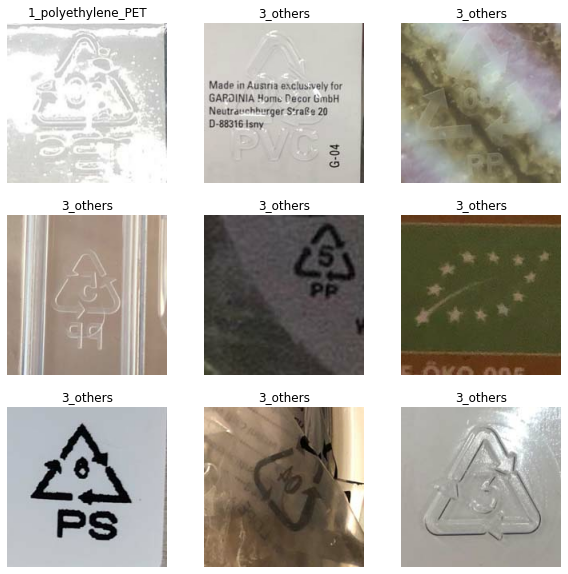

In [33]:
# Get a look at what we are training on

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [34]:
# Prefetch images to memory, to make training faster

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [35]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [36]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [37]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [38]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [39]:
# Keep the pre-trained weights, set this to true to retrain the whole model.
base_model.trainable = False

In [40]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [41]:
num_classes = len(class_names)

prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [42]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [43]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(), # lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 200, 200, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 200, 200, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [45]:
initial_epochs = 300

loss0, accuracy0 = model.evaluate(val_ds)

3/3 [==============================] - 2s 179ms/step - loss: 1.3625 - accuracy: 0.2353


In [46]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/300


20/20 [==============================] - 12s 375ms/step - loss: 0.8897 - accuracy: 0.6661 - val_loss: 0.6799 - val_accuracy: 0.7206
Epoch 2/300
20/20 [==============================] - 8s 375ms/step - loss: 0.6833 - accuracy: 0.7459 - val_loss: 0.6124 - val_accuracy: 0.7647
Epoch 3/300
20/20 [==============================] - 8s 374ms/step - loss: 0.6101 - accuracy: 0.7606 - val_loss: 0.7004 - val_accuracy: 0.7059
Epoch 4/300
20/20 [==============================] - 8s 388ms/step - loss: 0.6248 - accuracy: 0.7606 - val_loss: 0.5886 - val_accuracy: 0.7647
Epoch 5/300
20/20 [==============================] - 8s 376ms/step - loss: 0.5328 - accuracy: 0.8013 - val_loss: 0.5962 - val_accuracy: 0.7647
Epoch 6/300
20/20 [==============================] - 8s 373ms/step - loss: 0.5467 - accuracy: 0.7899 - val_loss: 0.5385 - val_accuracy: 0.7794
Epoch 7/300
20/20 [==============================] - 8s 378ms/step - loss: 0.5107 - accuracy: 0.8029 - val_loss: 0.5761 - val_accuracy: 0.7353
Epoch 8/30

20/20 [==============================] - 10s 505ms/step - loss: 0.3261 - accuracy: 0.8876 - val_loss: 0.6120 - val_accuracy: 0.7794
Epoch 59/300
20/20 [==============================] - 10s 512ms/step - loss: 0.3384 - accuracy: 0.8730 - val_loss: 0.5839 - val_accuracy: 0.7647
Epoch 60/300
20/20 [==============================] - 9s 437ms/step - loss: 0.2806 - accuracy: 0.8844 - val_loss: 0.5550 - val_accuracy: 0.7647
Epoch 61/300
20/20 [==============================] - 8s 419ms/step - loss: 0.2877 - accuracy: 0.8860 - val_loss: 0.5811 - val_accuracy: 0.7794
Epoch 62/300
20/20 [==============================] - 9s 424ms/step - loss: 0.2792 - accuracy: 0.9088 - val_loss: 0.6054 - val_accuracy: 0.7941
Epoch 63/300
20/20 [==============================] - 8s 421ms/step - loss: 0.2705 - accuracy: 0.8925 - val_loss: 0.5782 - val_accuracy: 0.7647
Epoch 64/300
20/20 [==============================] - 8s 420ms/step - loss: 0.2716 - accuracy: 0.8844 - val_loss: 0.5583 - val_accuracy: 0.7647
Epo

Epoch 115/300
20/20 [==============================] - 9s 464ms/step - loss: 0.2429 - accuracy: 0.9104 - val_loss: 0.5616 - val_accuracy: 0.7794
Epoch 116/300
20/20 [==============================] - 9s 467ms/step - loss: 0.2479 - accuracy: 0.9023 - val_loss: 0.5802 - val_accuracy: 0.7941
Epoch 117/300
20/20 [==============================] - 9s 470ms/step - loss: 0.2270 - accuracy: 0.9121 - val_loss: 0.5779 - val_accuracy: 0.7941
Epoch 118/300
20/20 [==============================] - 9s 467ms/step - loss: 0.2560 - accuracy: 0.8893 - val_loss: 0.5445 - val_accuracy: 0.7941
Epoch 119/300
20/20 [==============================] - 10s 475ms/step - loss: 0.2745 - accuracy: 0.8893 - val_loss: 0.6452 - val_accuracy: 0.7794
Epoch 120/300
20/20 [==============================] - 9s 468ms/step - loss: 0.2398 - accuracy: 0.9121 - val_loss: 0.5620 - val_accuracy: 0.7647
Epoch 121/300
20/20 [==============================] - 9s 466ms/step - loss: 0.2859 - accuracy: 0.8909 - val_loss: 0.6431 - val_a

20/20 [==============================] - 10s 475ms/step - loss: 0.2576 - accuracy: 0.9007 - val_loss: 0.6556 - val_accuracy: 0.7941
Epoch 228/300
20/20 [==============================] - 9s 468ms/step - loss: 0.2856 - accuracy: 0.8941 - val_loss: 0.6508 - val_accuracy: 0.7794
Epoch 229/300
20/20 [==============================] - 9s 469ms/step - loss: 0.2248 - accuracy: 0.9088 - val_loss: 0.6415 - val_accuracy: 0.7794
Epoch 230/300
20/20 [==============================] - 9s 467ms/step - loss: 0.2570 - accuracy: 0.9023 - val_loss: 0.7384 - val_accuracy: 0.8088
Epoch 231/300
20/20 [==============================] - 10s 472ms/step - loss: 0.2803 - accuracy: 0.8844 - val_loss: 0.6667 - val_accuracy: 0.7794
Epoch 232/300
20/20 [==============================] - 10s 480ms/step - loss: 0.2103 - accuracy: 0.9316 - val_loss: 0.6826 - val_accuracy: 0.7941
Epoch 233/300
20/20 [==============================] - 10s 464ms/step - loss: 0.2336 - accuracy: 0.8990 - val_loss: 0.6717 - val_accuracy: 0.

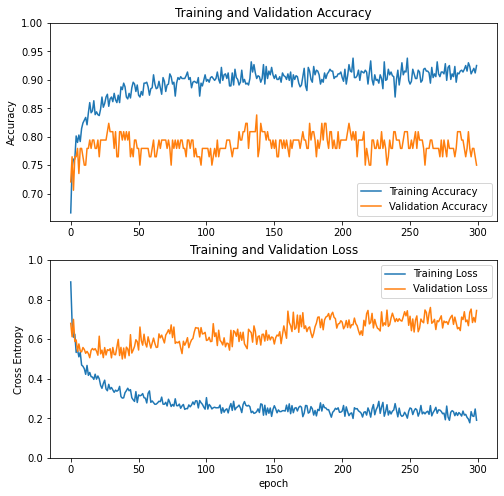

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [48]:
export_path = "F:\Kuliah\Bangkit 2022\Capstone\saved_model2"
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: F:\Kuliah\Bangkit 2022\Capstone\saved_model2\assets


INFO:tensorflow:Assets written to: F:\Kuliah\Bangkit 2022\Capstone\saved_model2\assets


'F:\\Kuliah\\Bangkit 2022\\Capstone\\saved_model2'

In [49]:
# Understand our Input data files. For example, 
# how many files are there, what are the resolutions

import os
from collections import Counter
import PIL
import PIL.Image

for dirname, _, filenames in os.walk(data_dir):
    c = Counter()
    
    for filename in filenames:
        with PIL.Image.open(str(os.path.join(dirname, filename))) as im:
            c.update([im.size])
    
    print(os.path.basename(dirname))
    
    for key, value in c.items():
        print(key, value)

    print()

seven_plastics

1_polyethylene_PET
(200, 200) 110
(200, 199) 5
(199, 200) 6

2_high_density_polyethylene_PE-HD
(200, 200) 72
(199, 200) 4

3_others
(200, 200) 447
(200, 192) 1
(200, 199) 17
(199, 200) 13
(180, 200) 1
(200, 130) 1
(200, 176) 1
(150, 200) 1
(200, 198) 1
(198, 200) 2



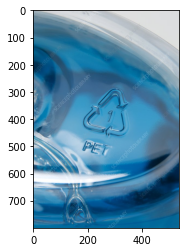

1/1 [==============================] - 1s 805ms/step
[[ 1.1527917  -8.68377    -0.86466026]]
PET


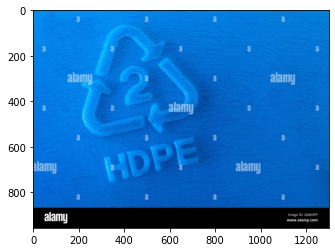

1/1 [==============================] - 0s 57ms/step
[[-4.9249096 -9.200377   1.7062037]]
Others


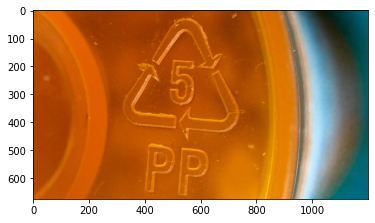

1/1 [==============================] - 0s 42ms/step
[[-1.0228194e+00 -9.2433958e+00 -7.8584254e-04]]
Others


In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

CLASS_NAMES = ['PET', 'HDPE', 'Others']

new_model = tf.keras.models.load_model('saved_model2')

test_path = "F:/Kuliah/Bangkit 2022/Capstone/test"

for image in os.listdir(test_path):
    if(image == '.ipynb_checkpoints'):
        continue
    img = cv2.imread(test_path+"/"+image)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     # as opencv loads in BGR format by default, we want to show it in RGB.
    plt.show()
    
    img = cv2.resize(img,(200,200))
    img = np.expand_dims(img,0)
    predict = new_model.predict(img)
#   print(image)
    print(predict)
    result = CLASS_NAMES[predict.argmax(axis=1)[0]]
    print(result)

In [2]:
import tensorflow as tf

saved_model_dir = "saved_model2"

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)